In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


2024-05-28 11:46:50.611425: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 11:46:50.611520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 11:46:50.736964: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.15.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import pandas as pd

summary = pd.read_csv('/kaggle/input/ml-final-dataset/news_summary.csv',
                      encoding='iso-8859-1')
raw = pd.read_csv('/kaggle/input/ml-final-dataset/news_summary_more.csv',
                  encoding='iso-8859-1')

In [3]:
pre1 = raw.iloc[:, 0:2].copy()
pre2 = summary.iloc[:, 0:6].copy()

# To increase the intake of possible text values to build a reliable model
pre2['text'] = pre2['author'].str.cat(pre2['date'
        ].str.cat(pre2['read_more'].str.cat(pre2['text'
        ].str.cat(pre2['ctext'], sep=' '), sep=' '), sep=' '), sep=' ')

pre = pd.DataFrame()
pre['text'] = pd.concat([pre1['text'], pre2['text']], ignore_index=True)
pre['summary'] = pd.concat([pre1['headlines'], pre2['headlines']],
                           ignore_index=True)

In [4]:
import re

# Remove non-alphabetic characters (Data Cleaning)
def text_strip(column):

    for row in column:
        row = re.sub("(\\t)", " ", str(row)).lower()
        row = re.sub("(\\r)", " ", str(row)).lower()
        row = re.sub("(\\n)", " ", str(row)).lower()

        # Remove _ if it occurs more than one time consecutively
        row = re.sub("(__+)", " ", str(row)).lower()

        # Remove - if it occurs more than one time consecutively
        row = re.sub("(--+)", " ", str(row)).lower()

        # Remove ~ if it occurs more than one time consecutively
        row = re.sub("(~~+)", " ", str(row)).lower()

        # Remove + if it occurs more than one time consecutively
        row = re.sub("(\+\++)", " ", str(row)).lower()

        # Remove . if it occurs more than one time consecutively
        row = re.sub("(\.\.+)", " ", str(row)).lower()

        # Remove the characters - <>()|&©ø"',;?~*!
        row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(row)).lower()

        # Remove mailto:
        row = re.sub("(mailto:)", " ", str(row)).lower()

        # Remove \x9* in text
        row = re.sub(r"(\\x9\d)", " ", str(row)).lower()

        # Replace INC nums to INC_NUM
        row = re.sub("([iI][nN][cC]\d+)", "INC_NUM", str(row)).lower()

        # Replace CM# and CHG# to CM_NUM
        row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(row)).lower()

        # Remove punctuations at the end of a word
        row = re.sub("(\.\s+)", " ", str(row)).lower()
        row = re.sub("(\-\s+)", " ", str(row)).lower()
        row = re.sub("(\:\s+)", " ", str(row)).lower()

        # Replace any url to only the domain name
        try:
            url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(row))
            repl_url = url.group(3)
            row = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(row))
        except:
            pass

        # Remove multiple spaces
        row = re.sub("(\s+)", " ", str(row)).lower()

        # Remove the single character hanging between any two spaces
        row = re.sub("(\s+.\s+)", " ", str(row)).lower()

        yield row

In [5]:
processed_text = text_strip(pre['text'])
processed_summary = text_strip(pre['summary'])

In [6]:
import spacy
from time import time

nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser'])

# Process text as batches and yield Doc objects in order
text = [str(doc) for doc in nlp.pipe(processed_text, batch_size=1000)]

summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(processed_summary, batch_size=5000)]

In [7]:
text[1]

'kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending 2000 cred coins users get one cred coin per rupee of bill paid which can be used to avail rewards from brands like ixigo bookmyshow ubereats cult.fit and more.'

In [8]:
summary[1]

'_START_ delhi techie wins free food from swiggy for one year on cred _END_'

In [9]:
pre['cleaned_text'] = pd.Series(text)
pre['cleaned_summary'] = pd.Series(summary)

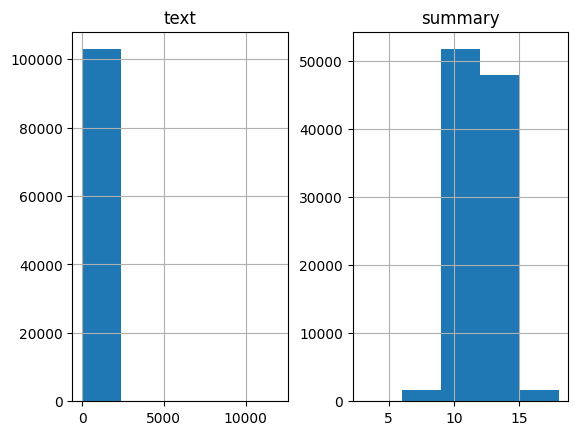

In [10]:
import matplotlib.pyplot as plt

text_count = []
summary_count = []

for sent in pre['cleaned_text']:
    text_count.append(len(sent.split()))
    
for sent in pre['cleaned_summary']:
    summary_count.append(len(sent.split()))

graph_df = pd.DataFrame() 

graph_df['text'] = text_count
graph_df['summary'] = summary_count

graph_df.hist(bins = 5)
plt.show()

In [11]:
# Check how much % of text have 0-100 words
cnt = 0
for i in pre['cleaned_text']:
    if len(i.split()) <= 100:
        cnt = cnt + 1
print(cnt / len(pre['cleaned_text']))

0.9578389933440218


In [12]:
# Model to summarize the text between 0-40 words for Summary and 0-200 words for Text
max_text_len = 200
max_summary_len = 40

In [13]:
# Select the Summaries and Text which fall below max length 

import numpy as np

cleaned_text = np.array(pre['cleaned_text'])
cleaned_summary= np.array(pre['cleaned_summary'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len:
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre = pd.DataFrame({'text': short_text,'summary': short_summary})

In [16]:
post_pre.head(10)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,_START_ upgrad learner switches to career in m...
1,kunal shah credit card bill payment platform c...,_START_ delhi techie wins free food from swigg...
2,new zealand defeated india by wickets in the f...,_START_ new zealand end rohit sharma-led india...
3,with aegon life iterm insurance plan customers...,_START_ aegon life iterm insurance plan helps ...
4,speaking about the sexual harassment allegatio...,_START_ have known hirani for yrs what if meto...
5,pakistani singer rahat fateh ali khan has deni...,_START_ rahat fateh ali khan denies getting no...
6,india recorded their lowest odi total in new z...,_START_ india get all out for 92 their lowest ...
7,weeks after ex-cbi director alok verma told th...,_START_ govt directs alok verma to join work d...
8,andhra pradesh cm chandrababu naidu has said w...,_START_ called pm modi sir 10 times to satisfy...
9,congress candidate shafia zubair won the ramga...,_START_ cong wins ramgarh bypoll in rajasthan ...


In [17]:
post_pre['summary'] = post_pre['summary'].apply(lambda x: 'sostok ' + x \
        + ' eostok')



In [18]:
post_pre.head(10)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,sostok _START_ upgrad learner switches to care...
1,kunal shah credit card bill payment platform c...,sostok _START_ delhi techie wins free food fro...
2,new zealand defeated india by wickets in the f...,sostok _START_ new zealand end rohit sharma-le...
3,with aegon life iterm insurance plan customers...,sostok _START_ aegon life iterm insurance plan...
4,speaking about the sexual harassment allegatio...,sostok _START_ have known hirani for yrs what ...
5,pakistani singer rahat fateh ali khan has deni...,sostok _START_ rahat fateh ali khan denies get...
6,india recorded their lowest odi total in new z...,sostok _START_ india get all out for 92 their ...
7,weeks after ex-cbi director alok verma told th...,sostok _START_ govt directs alok verma to join...
8,andhra pradesh cm chandrababu naidu has said w...,sostok _START_ called pm modi sir 10 times to ...
9,congress candidate shafia zubair won the ramga...,sostok _START_ cong wins ramgarh bypoll in raj...


In [20]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(post_pre["text"]),
    np.array(post_pre["summary"]),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [22]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [23]:
thresh = 5

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1

In [24]:
print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

% of rare words in vocabulary:  62.64256536458008


In [25]:
# Prepare a tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences to integer sequences 
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1



In [26]:
print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 29906


In [27]:
# Prepare a tokenizer on testing data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh = 5

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

# Convert text sequences to integer sequences 
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

# Pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

# Size of vocabulary (+1 for padding token)
y_voc = y_tokenizer.num_words + 1



% of rare words in vocabulary: 62.39955907521829


In [28]:
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 12963


In [29]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []

for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

In [30]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

In [31]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, \
    Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [32]:
latent_dim = 300
embedding_dim = 300

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim,
                    trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 300)  │  8,971,800 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 200,      │    721,200 │ embedding[0][0]   │
│                     │ 300), (None,      │            │                   │
│                     │ 300), (None,      │            │                   │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 200,      │    721,200 │ lstm[0][0]        │
│                     │ 300), (None,      │            │                   │
│                     │ 300), (None,      │            │                   │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 300) │  3,888,900 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 200,      │    721,200 │ lstm_1[0][0]      │
│                     │ 300), (None,      │            │                   │
│                     │ 300), (None,      │            │                   │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │    721,200 │ embedding_1[0][0… │
│                     │ 300), (None,      │            │ lstm_2[0][1],     │
│                     │ 300), (None,      │            │ lstm_2[0][2]      │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │  3,901,863 │ lstm_3[0][0]      │
│ (TimeDistributed)   │ 12963)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,647,363 (74.95 MB)

 Trainable params: 19,647,363 (74.95 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
from tensorflow.keras.optimizers import Adam

# Compile the model with Adam optimizer and a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

# Set up early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)


In [37]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=50,
    callbacks=[es],
    batch_size=128,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
    )

Epoch 1/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 592s 849ms/step - loss: 1.8467 - val_loss: 1.7689
Epoch 2/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 595s 852ms/step - loss: 1.7582 - val_loss: 1.6784
Epoch 3/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 593s 849ms/step - loss: 1.6603 - val_loss: 1.6052
Epoch 4/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 592s 848ms/step - loss: 1.5784 - val_loss: 1.5526
Epoch 5/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 592s 848ms/step - loss: 1.5125 - val_loss: 1.5121
Epoch 6/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 621s 847ms/step - loss: 1.4578 - val_loss: 1.4804
Epoch 7/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 592s 849ms/step - loss: 1.4084 - val_loss: 1.4547
Epoch 8/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 593s 849ms/step - loss: 1.3667 - val_loss: 1.4340
Epoch 9/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 589s 845ms/step - loss: 1.3315 - val_loss: 1.4183
Epoch 10/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 586s 840ms/step - loss: 1.2942 - val_loss: 1.4062
Epoch 11/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 587s 840ms/step - loss: 1.2648 - val_loss: 1.3916
Epoch 12

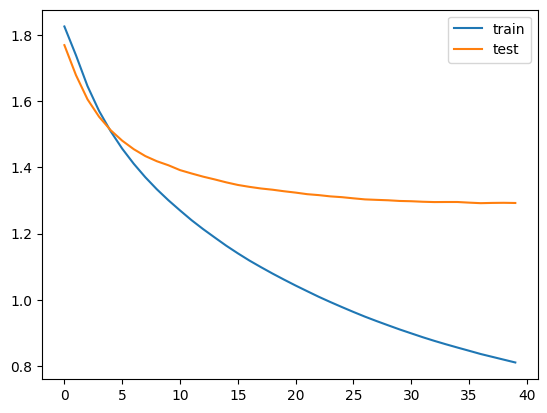

In [38]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [39]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [40]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [41]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [42]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
            != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

In [44]:
for i in range(0, 19):
    print ('Review:', seq2text(x_tr[i]))
    print ('Original summary:', seq2summary(y_tr[i]))
    print ('Predicted summary:', decode_sequence(x_tr[i].reshape(1,
           max_text_len)))
    print ('\n')

Review: a professor has been jailed for life in hong kong for murdering his wife and daughter using yoga ball filled with carbon monoxide the 53 year old had placed the ball in the boot of the car and the gas leaked out his wife and daughter were found by the roadside in the locked car in 2015 
Original summary: start man who killed wife daughter with yoga ball jailed for life end 
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted summary:  start man who shot wife and death shot dead in us end


Revie

In [45]:
# After training the model
model.save('summarizer_model.h5')


In [46]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('/kaggle/working/summarizer_model.h5')

# Confirm the model is loaded correctly by checking the summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 300)  │  8,971,800 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 200,      │    721,200 │ embedding[0][0]   │
│                     │ 300), (None,      │            │                   │
│                     │ 300), (None,      │            │                   │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 200,      │    721,200 │ lstm[0][0]        │
│                     │ 300), (None,      │            │                   │
│                     │ 300), (None,      │            │                   │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 300) │  3,888,900 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 200,      │    721,200 │ lstm_1[0][0]      │
│                     │ 300), (None,      │            │                   │
│                     │ 300), (None,      │            │                   │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │    721,200 │ embedding_1[0][0… │
│                     │ 300), (None,      │            │ lstm_2[0][1],     │
│                     │ 300), (None,      │            │ lstm_2[0][2]      │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None,      │  3,901,863 │ lstm_3[0][0]      │
│ (TimeDistributed)   │ 12963)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,647,365 (74.95 MB)

 Trainable params: 19,647,363 (74.95 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)